# **Importing Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

!pip install mlflow --quiet

ERROR: Cannot uninstall cryptography 41.0.7, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps cryptography==41.0.7'.


In [2]:
import mlflow
import os

mlflow.set_tracking_uri("file:/kaggle/working/mlruns")
mlflow.set_experiment("Fraud detection")

<Experiment: artifact_location='file:///kaggle/working/mlruns/530783897142737171', creation_time=1760414820551, experiment_id='530783897142737171', last_update_time=1760414820551, lifecycle_stage='active', name='Fraud detection', tags={}>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import shap

# **EDA**

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/credit-card-transactions-dataset/credit_card_transactions.csv',
                parse_dates=['trans_date_trans_time', 'dob'])

In [5]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [6]:
df.shape

(1296675, 24)

In [7]:
# Check for missing values
df.isnull().sum()

Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            195973
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1296675 non-null  int64         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   merchant               1296675 non-null  object        
 4   category               1296675 non-null  object        
 5   amt                    1296675 non-null  float64       
 6   first                  1296675 non-null  object        
 7   last                   1296675 non-null  object        
 8   gender                 1296675 non-null  object        
 9   street                 1296675 non-null  object        
 10  city                   1296675 non-null  object        
 11  state                  1296675 non-null  object        
 12  zip                    12966

In [9]:
df['merchant'].value_counts()

merchant
fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
                                        ... 
fraud_Douglas, DuBuque and McKenzie      775
fraud_Treutel-King                       775
fraud_Medhurst, Labadie and Gottlieb     759
fraud_Reichert-Weissnat                  753
fraud_Hahn, Douglas and Schowalter       727
Name: count, Length: 693, dtype: int64

In [10]:
df['category'].value_counts()

category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64

In [11]:
df['gender'].value_counts()

gender
F    709863
M    586812
Name: count, dtype: int64

In [12]:
df['city'].value_counts()

city
Birmingham     5617
San Antonio    5130
Utica          5105
Phoenix        5075
Meridian       5060
               ... 
Karns City        7
Bruce             7
Claypool          7
Streator          7
Vacaville         7
Name: count, Length: 894, dtype: int64

`City` has high cardinality with some rare categories

In [13]:
df['state'].value_counts()

state
TX    94876
NY    83501
PA    79847
CA    56360
OH    46480
MI    46154
IL    43252
FL    42671
AL    40989
MO    38403
MN    31714
AR    31127
NC    30266
WI    29368
VA    29250
SC    29190
KY    28475
IN    27580
IA    26985
OK    26671
MD    26193
GA    26063
WV    25691
NJ    24603
NE    24168
KS    22996
MS    21188
LA    20965
WY    19322
WA    18924
OR    18597
TN    17554
ME    16505
NM    16407
ND    14786
CO    13880
MA    12376
SD    12324
VT    11768
MT    11754
AZ    10770
UT    10699
NH     8278
CT     7702
NV     5607
ID     5545
DC     3613
HI     2559
AK     2120
RI      550
DE        9
Name: count, dtype: int64

In [14]:
df['job'].value_counts()

job
Film/video editor                 9779
Exhibition designer               9199
Naval architect                   8684
Surveyor, land/geomatics          8680
Materials engineer                8270
                                  ... 
Veterinary surgeon                   8
Armed forces technical officer       8
Ship broker                          7
Contracting civil engineer           7
Warehouse manager                    7
Name: count, Length: 494, dtype: int64

## EDA summary

Unnecessary features:
- `Unnamed: 0`
- `trans_num`
- `unix_time`
- `zip`
- `first`
- `last`
- `cc_num`
- `street`
- `merch_zipcode`
- `long`
- `lat`
- `merch_long`
- `merch_lat`

We might benefit from extracting day of week and grouping time of transaction from `trans_date_trans_time` column

Given `dob` and `trans_date_trans_time` may be used to calculate age at transaction.

`merchant` and `job` columns need to be target encoded as they have huge number of categories

# **Preprocessing**

In [15]:
new_df = df.copy()

## Feature Engineering

### Day of week

In [16]:
# Creating day of week
new_df['dow'] = new_df['trans_date_trans_time'].dt.dayofweek

In [17]:
new_df.groupby('dow')['is_fraud'].mean()

dow
0    0.004648
1    0.005835
2    0.006554
3    0.006844
4    0.007086
5    0.006106
6    0.004853
Name: is_fraud, dtype: float64

Fraud is lowest on `Monday` and `Sunday`.

Fraud rates peak on `Friday` (0.0071) and `Thursday` (0.0068).

### Part of day

In [18]:
# Function to map given hours to part of day 
def map_hours(hour):
    if 12 > hour > 6:
        return 'Morning'
    elif 16 > hour > 12:
        return 'Afternoon'
    elif 20 > hour > 16:
        return 'Evening'
    else:
        return 'Night'

In [19]:
# Creating part of day from hours
new_df['time'] = new_df['trans_date_trans_time'].dt.hour.map(map_hours)

In [20]:
new_df.groupby('time')['is_fraud'].mean()

time
Afternoon    0.001253
Evening      0.001218
Morning      0.001108
Night        0.009796
Name: is_fraud, dtype: float64

We can see that `Night` is a strong signal for fraud compared to the others.

### Age during transaction

In [21]:
# Compute age as difference between transaction time and date of birth
new_df['age'] = (new_df['trans_date_trans_time'] - new_df['dob']).dt.days

### Drop redundant columns

In [22]:
# Drop unnecessary columns
new_df = new_df.drop(columns=['Unnamed: 0', 'city', 'zip', 'trans_num', 'unix_time', 'first', 'last', 'cc_num', 'street', 'merch_zipcode', 'long', 'lat', 'merch_long', 'merch_lat', 'trans_date_trans_time', 'dob'])

In [23]:
new_df.head()

,merchant,category,amt,gender,state,city_pop,job,is_fraud,dow,time,age
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,NC,3495,"Psychologist, counselling",0,1,Night,11255
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,WA,149,Special educational needs teacher,0,1,Night,14804
2,fraud_Lind-Buckridge,entertainment,220.11,M,ID,4154,Nature conservation officer,0,1,Night,20801
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,MT,1939,Patent attorney,0,1,Night,18982
4,fraud_Keeling-Crist,misc_pos,41.96,M,VA,99,Dance movement psychotherapist,0,1,Night,11967


## Train test split

In [24]:
# Separate features and target variable
X = new_df.drop(columns=['is_fraud'])
y = new_df['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## Encoding

### Target Encoding

In [25]:
te_features = ['job', 'merchant']

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create encoded placeholders
X_train_encoded = X_train.copy()
for col in te_features:
    X_train_encoded[f'{col}_encoded'] = np.nan

# Loop through folds
for train_idx, val_idx in kf.split(X_train):
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    
    for col in te_features:
        encoder = TargetEncoder(cols=[col])
        encoder.fit(X_fold_train[[col]], y_fold_train)
        X_fold_val_encoded = encoder.transform(X_fold_val[[col]])

        # Assign encoded values to correct rows (match by position)
        X_train_encoded.loc[X_train_encoded.index[val_idx], f'{col}_encoded'] = X_fold_val_encoded[col].values

In [27]:
# Create a copy of test set
X_test_encoded = X_test.copy()

# For each feature, fit encoder on full training set and transform test set
for col in te_features:
    encoder = TargetEncoder(cols=[col])
    encoder.fit(X_train[[col]], y_train)
    X_test_encoded[f'{col}_encoded'] = encoder.transform(X_test[[col]])[col]

In [28]:
X_train_encoded.drop(columns=te_features, inplace=True)
X_test_encoded.drop(columns=te_features, inplace=True)

### OHE and scaling

In [29]:
ohe_cols = ['category', 'gender', 'state', 'time']
scaling_cols = list(X_train_encoded.select_dtypes(exclude='object').columns)

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_cols),
        ('scale', StandardScaler(), scaling_cols)
    ]
)

# Model training

In [31]:
models = {
    "lgbm": LGBMClassifier(device='gpu', random_state=45),
    "xgb": XGBClassifier(device='cuda', tree_method='hist', random_state=45),
    "rf": LGBMClassifier(bagging_fraction= 0.8, boosting_type='rf', feature_fraction=0.8, device='gpu', random_state=45)
}

In [32]:
trained_models = {}

In [33]:
for name, model in models.items():
    # Create pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=45)),
        ('classifier', model)
    ])
    
    with mlflow.start_run(run_name=name):
        # Fit
        pipe.fit(X_train_encoded, y_train)
        
        # Log model
        mlflow.sklearn.log_model(pipe, name=f"model_{name}")
        
        # Log parameters
        mlflow.log_params(model.get_params())
        
        # Predict on test set
        y_pred = pipe.predict(X_test_encoded)
        
        # Predict on the test set
        y_pred = pipe.predict(X_test_encoded)
        
        # Calculate precision, recall, and the classification report
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        report = classification_report(y_test, y_pred)
        
        # Log metrics
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        
        # Log the classification report as a text artifact
        mlflow.log_text(report, f"classification_report_{name}.txt")
        
        print(f"Trained and logged {name} with scores")
    
    trained_models[name] = pipe

[LightGBM] [Info] Number of positive: 902418, number of negative: 902418
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18784
[LightGBM] [Info] Number of data points in the train set: 1804836, number of used features: 77
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (13.77 MB) transferred to GPU in 0.018971 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2025/10/14 04:13:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpcdeqdlo7/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/14 04:13:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained and logged lgbm with scores


2025/10/14 04:14:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpzovjaf7y/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/14 04:14:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained and logged xgb with scores
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 902418, number of negative: 902418
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18784
[LightGBM] [Info] Number of data points in the train set: 1804836, number of used features: 77
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGB

2025/10/14 04:14:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpekpji1w_/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/14 04:14:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Trained and logged rf with scores


## XGB

In [34]:
xgb_pred = trained_models['xgb'].predict(X_test_encoded)
report = classification_report(y_test, xgb_pred)

In [35]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.55      0.88      0.68      2252

    accuracy                           1.00    389003
   macro avg       0.78      0.94      0.84    389003
weighted avg       1.00      1.00      1.00    389003



## lgbm

In [36]:
lgbm_pred = trained_models['lgbm'].predict(X_test_encoded)
report = classification_report(y_test, lgbm_pred)

In [37]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    386751
           1       0.42      0.89      0.57      2252

    accuracy                           0.99    389003
   macro avg       0.71      0.94      0.78    389003
weighted avg       1.00      0.99      0.99    389003



## RF

In [38]:
rf_pred = trained_models['rf'].predict(X_test_encoded)
report = classification_report(y_test, rf_pred)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [39]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    386751
           1       0.11      0.95      0.19      2252

    accuracy                           0.95    389003
   macro avg       0.55      0.95      0.59    389003
weighted avg       0.99      0.95      0.97    389003



# Hyperparameter Tuning (XGB)

In [40]:
pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=45)),
        ('classifier', XGBClassifier(random_state=45))
])

param_grid = {
    'classifier__gamma': [0, 0.1, 0.3, 0.5],
    'classifier__scale_pos_weight': [1, 10, 25, 50, 100],
    'classifier__n_estimators': [100, 300, 500],
    'classifier__reg_alpha': [0, 0.01, 0.1],
    'classifier__reg_lambda': [1, 1.5, 2],
    'classifier__device': ['cuda'],
    'classifier__tree_method': ['hist']
}

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
)

In [41]:
# Start MLflow run
with mlflow.start_run(run_name="XGB_RandomSearch_Tuning"):
    # Fit the model
    random_search.fit(X_train_encoded, y_train)

    # Get best model, params, and metrics
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_cv_auc = random_search.best_score_

    # Predict and evaluate on test set
    y_pred = best_model.predict(X_test_encoded)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Log parameters, metrics, and model to MLflow
    mlflow.log_params(best_params)
    mlflow.log_metric("cv_auc", best_cv_auc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric('recall', recall)

    mlflow.sklearn.log_model(best_model, name="tuned_model")

    print("Best CV AUC score:", best_cv_auc)
    print("Model and metrics logged to MLflow.")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Fitting 3 folds for each of 20 candidates, totalling 60 fits


2025/10/14 04:31:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpwajm5mw8/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/14 04:31:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best CV AUC score: 0.9965743492278399
Model and metrics logged to MLflow.


In [42]:
report = classification_report(y_pred, y_test)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386217
           1       0.86      0.70      0.77      2786

    accuracy                           1.00    389003
   macro avg       0.93      0.85      0.88    389003
weighted avg       1.00      1.00      1.00    389003



In [43]:
import shutil
shutil.make_archive("/kaggle/working/mlflow_logs", 'zip', "/kaggle/working/mlruns")

'/kaggle/working/mlflow_logs.zip'

In [44]:
# Get feature names after transformation
ohe = best_model.named_steps['preprocessor'].named_transformers_['ohe']
ohe_feature_names = ohe.get_feature_names_out(ohe_cols)

scaled_feature_names = scaling_cols  # StandardScaler doesn't change names

# Combine them in correct order (same as ColumnTransformer order)
feature_names = np.concatenate([ohe_feature_names, scaled_feature_names])

# Get feature importances from XGBoost
importances = best_model.named_steps['classifier'].feature_importances_

# Map to DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

In [45]:
def get_original_column(feat_name):
    for col in ohe_cols:
        if feat_name.startswith(col + "_"):
            return col
    if feat_name in scaling_cols:
        return feat_name

In [46]:
feature_importance_df['group'] = feature_importance_df['feature'].apply(get_original_column)

# Group importances
grouped_importance = feature_importance_df.groupby('group')['importance'].sum().sort_values(ascending=False)

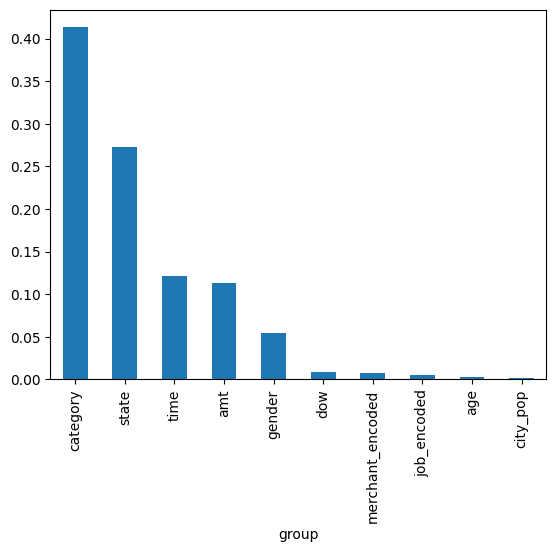

In [47]:
grouped_importance.plot(kind='bar')
plt.show()

# Shap Values

In [48]:
# Get the preprocessed (transformed) features
X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test_encoded.iloc[[20]])

# Extract the trained XGBoost model from pipeline
xgb_model = best_model.named_steps["classifier"]

# Use SHAP TreeExplainer for XGBoost
explainer = shap.Explainer(xgb_model)

In [49]:
X_transformed_df = pd.DataFrame(X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed,
                                columns=feature_names)

In [50]:
# Compute SHAP values on transformed data
shap_values = explainer(X_transformed_df)

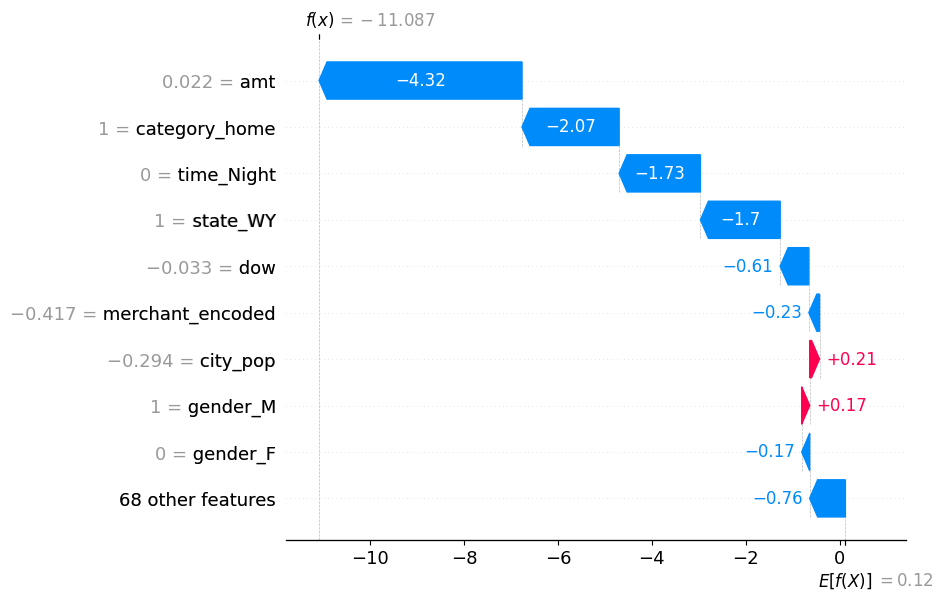

In [51]:
shap.plots.waterfall(shap_values[0])